# Data Preparation Notebook

The dataset we use for the demo is from a Kaggle Machine Learning competition  [« New York City Taxi Trip Duration »](https://www.kaggle.com/c/nyc-taxi-trip-duration) 

## Index

1. [Data structure](#Data-structure)
2. [Data loading](#Data-loading)
3. [Data cleaning](#Data-cleaning)
    - [Select useful columns & remove missing values](#Select-useful-columns-&-remove-missing-values)
    - [Drop data according to the coordinates](#Drop-data-according-to-the-coordinates)
    - [Split pickup and dropoff datetime](#Split-pickup-and-dropoff-datetime)
    - [Rename columns](#Rename-columns)
4. [Feature engineering](#Feature-engineering)
    - [Extract date & time features](#Extract-date-&-time-features)
    - [Compute trip distance](#Compute-trip-distance)
5. [Generate pickle file for clean data](#Generate-pickle-file-for-clean-data)
6. [Save DataPrep package](#Save-DataPrep-package)
7. [Load DataPrep package](#Load-DataPrep-package)

In [1]:
from IPython.display import display
from os import path
from tempfile import mkdtemp

import pandas as pd
import numpy as np
import azureml.dataprep as dprep

import matplotlib.pyplot as plt
import seaborn as sns

## Data structure

The dataset contains 1458644 trip records. There are 11 attributes related to each trip record.

- `id` - a unique identifier for each trip
- `vendor_id` - a code indicating the provider associated with the trip record
- `pickup_datetime` - date and time when the meter was engaged
- `dropoff_datetime` - date and time when the meter was disengaged
- `passenger_count` - the number of passengers in the vehicle (driver entered value)
- `pickup_longitude` - the longitude where the meter was engaged
- `pickup_latitude` - the latitude where the meter was engaged
- `dropoff_longitude` - the longitude where the meter was disengaged
- `dropoff_latitude` - the latitude where the meter was disengaged
- `store_and_fwd_flag` - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
- `trip_duration` - duration of the trip in seconds

## Data loading

In [2]:
dataset_path = "data/train.csv"

print("Retrieving data from the following source:")
print(dataset_path)

dataflow = dprep.read_csv(path = dataset_path)

dataflow.head(5)

Retrieving data from the following source:
data/train.csv


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982154846191406,40.767936706542969,-73.964630126953125,40.765602111816406,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415344238281,40.738563537597656,-73.999481201171875,40.731151580810547,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979026794433594,40.763938903808594,-74.005332946777344,40.710086822509766,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040283203125,40.719970703125,-74.01226806640625,40.706718444824219,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973052978515625,40.793209075927734,-73.972923278808594,40.782520294189453,N,435


Glimpse into columns types and column summary statistics with `get_profile()`. 

From the summary below, we notice that:

1. All the columns are STRING type.
2. There isn't any missing value in the dataset.
3. There are some outliers in several columns.

In [3]:
dataflow.get_profile()

,Type,Min,Max,Count,Missing Count,Error Count,Lower Quartile,Median,Upper Quartile,Standard Deviation,Mean
id,FieldType.STRING,id0000001,id4000000,1458644.0,0.0,0.0,,,,,
vendor_id,FieldType.STRING,1,2,1458644.0,0.0,0.0,,,,,
pickup_datetime,FieldType.STRING,2016-01-01 00:00:17,2016-06-30 23:59:39,1458644.0,0.0,0.0,,,,,
dropoff_datetime,FieldType.STRING,2016-01-01 00:03:31,2016-07-01 23:02:03,1458644.0,0.0,0.0,,,,,
passenger_count,FieldType.STRING,0,9,1458644.0,0.0,0.0,,,,,
pickup_longitude,FieldType.STRING,-121.93323516845703,-79.569732666015625,1458644.0,0.0,0.0,,,,,
pickup_latitude,FieldType.STRING,34.359695434570312,51.881084442138672,1458644.0,0.0,0.0,,,,,
dropoff_longitude,FieldType.STRING,-121.93320465087891,-80.355430603027344,1458644.0,0.0,0.0,,,,,
dropoff_latitude,FieldType.STRING,32.181140899658203,43.921028137207031,1458644.0,0.0,0.0,,,,,
store_and_fwd_flag,FieldType.STRING,N,Y,1458644.0,0.0,0.0,,,,,


## Data cleaning

### Select useful columns & remove missing values

In [4]:
all_columns = dprep.ColumnSelector(term=".*", use_regex=True)
drop_if_all_null = [all_columns, dprep.ColumnRelationship(dprep.ColumnRelationship.ALL)]
useful_columns = [
    "vendor_id", "dropoff_datetime", "dropoff_latitude", "dropoff_longitude",
    "pickup_datetime", "pickup_latitude", "pickup_longitude", "passenger_count", "store_and_fwd_flag", "trip_duration"
]

In [5]:
dataflow = (dataflow
     .replace_na(columns = all_columns)
     .drop_nulls(*drop_if_all_null)
     .keep_columns(columns=useful_columns))
dataflow.head(5)

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982154846191406,40.767936706542969,-73.964630126953125,40.765602111816406,N,455
1,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415344238281,40.738563537597656,-73.999481201171875,40.731151580810547,N,663
2,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979026794433594,40.763938903808594,-74.005332946777344,40.710086822509766,N,2124
3,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040283203125,40.719970703125,-74.01226806640625,40.706718444824219,N,429
4,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973052978515625,40.793209075927734,-73.972923278808594,40.782520294189453,N,435


### Drop data according to the coordinates

First of all, change the pick-up and drop_off coordinate (longitude & latitude) columns type into decimal. Then, glimpse into the coordinate disctribution.

In [6]:
decimal_type = dprep.TypeConverter(data_type=dprep.FieldType.DECIMAL)

dataflow = dataflow.set_column_types(type_conversions={
    "pickup_longitude": decimal_type,
    "pickup_latitude": decimal_type,
    "dropoff_longitude": decimal_type,
    "dropoff_latitude": decimal_type
})

dataflow.keep_columns(columns=[
    "pickup_longitude", "pickup_latitude", 
    "dropoff_longitude", "dropoff_latitude"
]).get_profile()

,Type,Min,Max,Count,Missing Count,Error Count,Lower Quartile,Median,Upper Quartile,Standard Deviation,Mean
pickup_longitude,FieldType.DECIMAL,-121.933342,-61.335529,1458644.0,0.0,0.0,-73.991899,-73.981702,-73.967340,0.070902,-73.973486
pickup_latitude,FieldType.DECIMAL,34.359695,51.881084,1458644.0,0.0,0.0,40.737349,40.754060,40.768339,0.032881,40.750921
dropoff_longitude,FieldType.DECIMAL,-121.933304,-61.335529,1458644.0,0.0,0.0,-73.991356,-73.979746,-73.963078,0.070643,-73.973416
dropoff_latitude,FieldType.DECIMAL,32.181141,43.921028,1458644.0,0.0,0.0,40.735865,40.754477,40.769770,0.035891,40.751800


In [7]:
# change dataflow to dataframe
df_tmp = dataflow.to_pandas_dataframe()

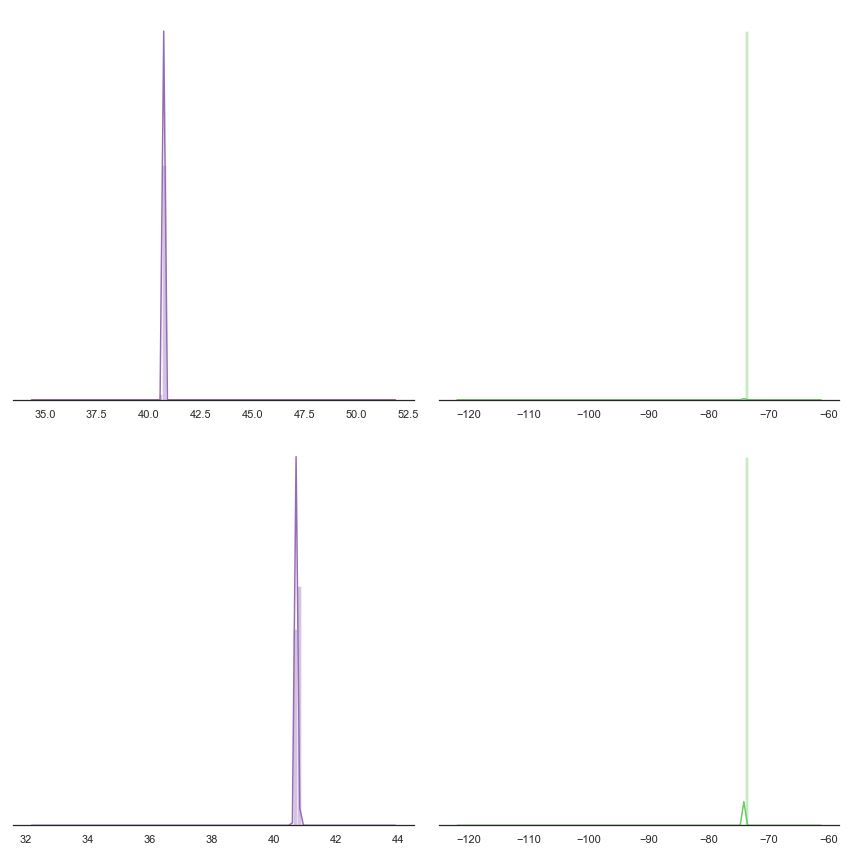

In [8]:
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(2,2,figsize=(12, 12), sharex=False, sharey = False)
sns.despine(left=True)
sns.distplot(df_tmp['pickup_latitude'].values, label = 'pickup_latitude',color="m", bins = 100, ax=axes[0,0])
sns.distplot(df_tmp['pickup_longitude'].values, label = 'pickup_longitude',color="g", bins =100, ax=axes[0,1])
sns.distplot(df_tmp['dropoff_latitude'].values, label = 'dropoff_latitude',color="m", bins =100, ax=axes[1,0])
sns.distplot(df_tmp['dropoff_longitude'].values, label = 'dropoff_longitude',color="g", bins =100, ax=axes[1,1])
plt.setp(axes, yticks=[])
plt.tight_layout()
plt.show()

From the plot above, we can not really observe the coordinates distribution, however it is obvious that pick and drop latitude are centered around 40 to 41, and longitude are situated around -74 ton-73. So, we rescale the longitude and latitude range to observe the distribution clearly.

In [9]:
df = df_tmp.loc[(df_tmp.pickup_latitude > 40.6) & (df_tmp.pickup_latitude < 40.9)]
df = df.loc[(df.dropoff_latitude>40.6) & (df.dropoff_latitude < 40.9)]
df = df.loc[(df.dropoff_longitude > -74.05) & (df.dropoff_longitude < -73.7)]
df = df.loc[(df.pickup_longitude > -74.05) & (df.pickup_longitude < -73.7)]
df_tmp2 = df.copy()

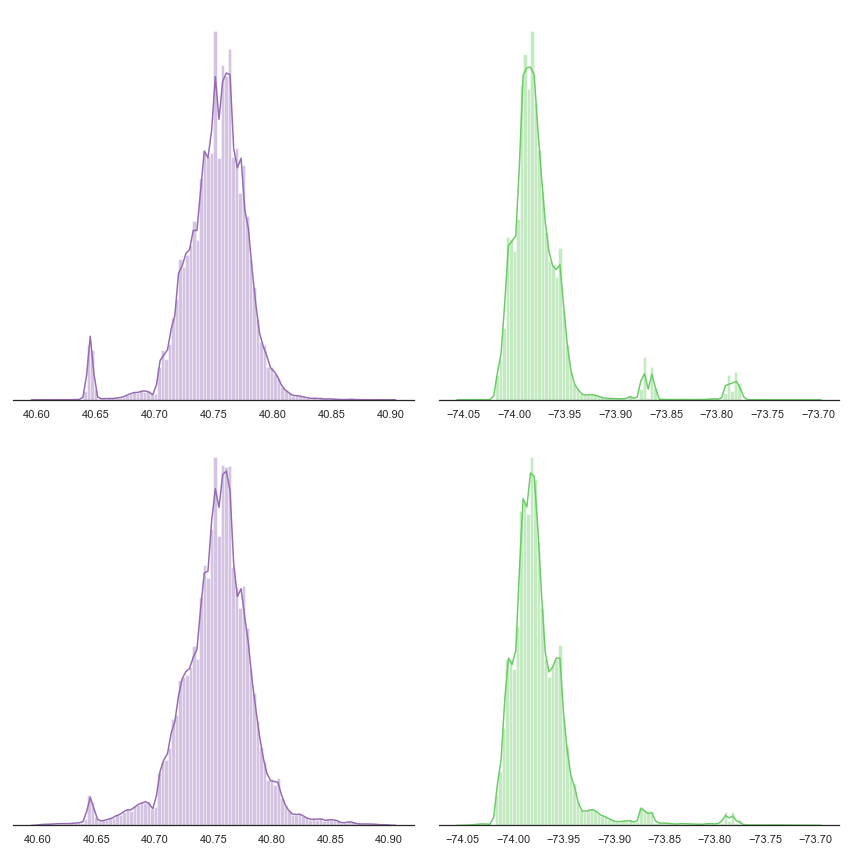

In [10]:
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(2,2,figsize=(12, 12), sharex=False, sharey = False)
sns.despine(left=True)
sns.distplot(df_tmp2['pickup_latitude'].values, label = 'pickup_latitude',color="m", bins = 100, ax=axes[0,0])
sns.distplot(df_tmp2['pickup_longitude'].values, label = 'pickup_longitude',color="g", bins =100, ax=axes[0,1])
sns.distplot(df_tmp2['dropoff_latitude'].values, label = 'dropoff_latitude',color="m", bins =100, ax=axes[1, 0])
sns.distplot(df_tmp2['dropoff_longitude'].values, label = 'dropoff_longitude',color="g", bins =100, ax=axes[1, 1])
plt.setp(axes, yticks=[])
plt.tight_layout()
plt.show()

The heatmaps below represent the pick-up & drop-off locations on the map of NYC.

In [41]:
import folium
from folium.plugins import HeatMap

m_pickup = folium.Map(location = [40.730610, -73.935242], titles = "pick-up coordinates", zoom_start = 10)

df_sam = df_tmp.sample(n = 20000)
data = np.array(df_sam[['pickup_latitude','pickup_longitude']]).tolist()

HeatMap(data).add_to(m_pickup)

m_pickup

In [42]:
import folium
from folium.plugins import HeatMap

m_dropoff = folium.Map(location = [40.730610, -73.935242], titles = "drop-off coordinates", zoom_start = 10)

df_sam = df_tmp.sample(n = 20000)
data = np.array(df_sam[['dropoff_latitude','dropoff_longitude']]).tolist()

HeatMap(data).add_to(m_dropoff)

m_dropoff

From the distribution plot and coordinates heatmap, we notice that there exists some locations that are not in NYC.

Thus , we filter out those locations that are note in the city border.

In [43]:
dataflow = (dataflow
    .filter(dprep.f_and(
        dprep.col("pickup_longitude") <= -73.72,
        dprep.col("pickup_longitude") >= -74.09,
        dprep.col("pickup_latitude") <= 40.88,
        dprep.col("pickup_latitude") >= 40.53,
        dprep.col("dropoff_longitude") <= -73.72,
        dprep.col("dropoff_longitude") >= -74.09,
        dprep.col("dropoff_latitude") <= 40.88,
        dprep.col("dropoff_latitude") >= 40.53
    )))

dataflow.keep_columns(columns=[
    "pickup_longitude", "pickup_latitude", 
    "dropoff_longitude", "dropoff_latitude"
]).get_profile()

,Type,Min,Max,Count,Missing Count,Error Count,Lower Quartile,Median,Upper Quartile,Standard Deviation,Mean
pickup_longitude,FieldType.DECIMAL,-74.089951,-73.720161,1452146.0,0.0,0.0,-73.991901,-73.981720,-73.967327,0.037802,-73.973539
pickup_latitude,FieldType.DECIMAL,40.531929,40.879696,1452146.0,0.0,0.0,40.737327,40.754006,40.768331,0.027908,40.750960
dropoff_longitude,FieldType.DECIMAL,-74.089996,-73.720009,1452146.0,0.0,0.0,-73.991280,-73.979772,-73.963088,0.033440,-73.973212
dropoff_latitude,FieldType.DECIMAL,40.531364,40.879993,1452146.0,0.0,0.0,40.736047,40.754497,40.769706,0.031468,40.751724


Now,we can construct pick-up and drop-off location maps based on our data filtered.

In [44]:
# change dataflow to dataframe
df_tmp = dataflow.to_pandas_dataframe()

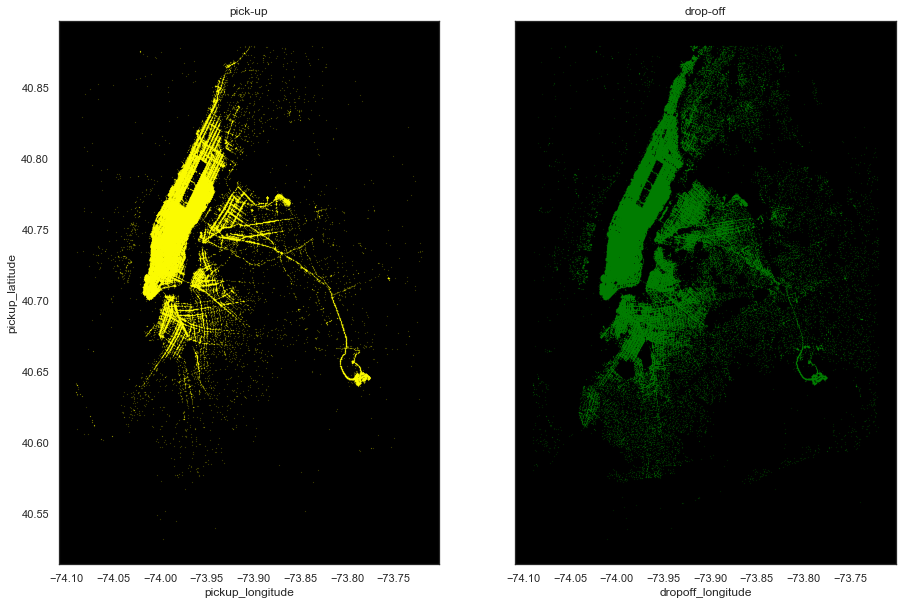

In [46]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(15,10))

df_tmp.plot(kind='scatter', x='pickup_longitude', y='pickup_latitude', color='yellow', s=.02, alpha=.6, subplots=True, ax=ax1)
ax1.set_title("pick-up")
ax1.set_facecolor('black')

df_tmp.plot(kind='scatter', x='dropoff_longitude', y='dropoff_latitude', color='green', s=.02, alpha=.6, subplots=True, ax=ax2)
ax2.set_title("drop-off")
ax2.set_facecolor('black') 

As we can see in the maps above, most of journeys have been to or from Manhattan, as Manhattan looks well-lit area in the map. Other intensive locations are the two airports, John F. Kennedy and LA Guardia Airport in Queens. All these seems reasonable. We can roughly conclude that our position related data is clean now.

### Split pickup and dropoff datetime

Split the pick-up and drop-off datetimes into a data column and a time column with `split_column_by_example`.

_**Note**_ : If the example parameter of `split_column_by_example` is omitted, we will automatically try to figure out where to split based on the data.

In [47]:
dataflow = (dataflow
    .split_column_by_example(source_column="pickup_datetime")
    .split_column_by_example(source_column="dropoff_datetime"))

dataflow.head(5)

# we can also use derive_column_by_example to split the columns
"""
dataflow.derive_column_by_example(
        source_columns='pickup_datetime',
        new_column_name='date',
        example_data=[('2016-03-14 17:24:55', '2016-03-14'), ('2016-06-12 00:43:35', '2016-06-12')]
    )\
    .derive_column_by_example(
        source_columns='pickup_datetime',
        new_column_name='time',
        example_data=[('2016-03-14 17:24:55', '17:24:55'), ('2016-06-12 00:43:35', '00:43:35')]
    ).head(5)
"""

"\ndataflow.derive_column_by_example(\n        source_columns='pickup_datetime',\n        new_column_name='date',\n        example_data=[('2016-03-14 17:24:55', '2016-03-14'), ('2016-06-12 00:43:35', '2016-06-12')]\n    )    .derive_column_by_example(\n        source_columns='pickup_datetime',\n        new_column_name='time',\n        example_data=[('2016-03-14 17:24:55', '17:24:55'), ('2016-06-12 00:43:35', '00:43:35')]\n    ).head(5)\n"

### Rename columns

Finally, assign meaningful names to the columns.

In [48]:
dataflow = (dataflow
    .rename_columns(column_pairs={
        "pickup_datetime_1": "pickup_date",
        "pickup_datetime_2": "pickup_time",
        "dropoff_datetime_1": "dropoff_date",
        "dropoff_datetime_2": "dropoff_time"
    }))

dataflow.head(5)

,vendor_id,pickup_datetime,pickup_date,pickup_time,dropoff_datetime,dropoff_date,dropoff_time,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,2,2016-03-14 17:24:55,2016-03-14,17:24:55,2016-03-14 17:32:30,2016-03-14,17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,1,2016-06-12 00:43:35,2016-06-12,00:43:35,2016-06-12 00:54:38,2016-06-12,00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,2,2016-01-19 11:35:24,2016-01-19,11:35:24,2016-01-19 12:10:48,2016-01-19,12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,2,2016-04-06 19:32:31,2016-04-06,19:32:31,2016-04-06 19:39:40,2016-04-06,19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,2,2016-03-26 13:30:55,2016-03-26,13:30:55,2016-03-26 13:38:10,2016-03-26,13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


## Feature engineering

### Extract date & time features

- split pick-up and drop-off date into day of week, day of month and month.
- split pick-up and drop-off time into hour, minute and second.

In [10]:
%%time
dataflow = dataflow\
    .derive_column_by_example(
        source_columns="pickup_date", 
        new_column_name="pickup_weekday", 
        example_data=[("2009-01-04", "Sunday"), ("2013-08-22", "Thursday")]
    )\
    .derive_column_by_example(
        source_columns="dropoff_date",
        new_column_name="dropoff_weekday",
        example_data=[("2013-08-22", "Thursday"), ("2013-11-03", "Sunday")]
    )\
    .split_column_by_example(source_column="pickup_date")\
    .split_column_by_example(source_column="pickup_time")\
    .split_column_by_example(source_column="dropoff_date")\
    .split_column_by_example(source_column="dropoff_time")\
    .split_column_by_example(source_column="pickup_time_1")\
    .split_column_by_example(source_column="dropoff_time_1")

dataflow.head(5)

Wall time: 16min 57s


After splitting the columns, we should drop some useless columns and rename the others.

In [11]:
%%time
dataflow = dataflow\
    .drop_columns(columns=[
        "pickup_date", "pickup_time", "dropoff_date", "dropoff_time", 
        "pickup_time_1", "dropoff_time_1", "pickup_datetime", "dropoff_datetime"
    ])\
    .rename_columns(column_pairs={
        "pickup_date_1": "pickup_year",
        "pickup_date_2": "pickup_month",
        "pickup_date_3": "pickup_monthday",
        "pickup_time_1_1": "pickup_hour",
        "pickup_time_1_2": "pickup_minute",
        "pickup_time_2": "pickup_second",
        "dropoff_date_1": "dropoff_year",
        "dropoff_date_2": "dropoff_month",
        "dropoff_date_3": "dropoff_monthday",
        "dropoff_time_1_1": "dropoff_hour",
        "dropoff_time_1_2": "dropoff_minute",
        "dropoff_time_2": "dropoff_second"
    })

dataflow.head(5)

Wall time: 609 ms


### Compute trip distance

We are supposed to change dataflow to Pandas dataframe in order to compute the trip distance.

In [12]:
%%time
pd_dataframe = dataflow.to_pandas_dataframe()

Wall time: 4min 4s


Define computation funcitons.

In [13]:
# Source:
# https://stackoverflow.com/questions/15736995/how-can-i-quickly-estimate-the-distance-between-two-latitude-longitude-points

from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371* c
    return km

def euclidian_distance(x):
    x1, y1 = np.float64(x["pickup_longitude"]), np.float64(x["pickup_latitude"])
    x2, y2 = np.float64(x["dropoff_longitude"]), np.float64(x["dropoff_latitude"])    
    return haversine(x1, y1, x2, y2)

In [14]:
%%time
pd_dataframe["distance"] = pd_dataframe[["pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude"]]\
                            .apply(euclidian_distance, axis=1)

Wall time: 2min


## Generate pickle file for clean data

In [15]:
pd_dataframe.head(5)

,vendor_id,pickup_year,pickup_month,pickup_monthday,pickup_weekday,pickup_hour,pickup_minute,pickup_second,dropoff_year,dropoff_month,...,dropoff_minute,dropoff_second,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,distance
0,2,2016,03,14,Monday,17,24,55,2016,03,...,32,30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,1.498521
1,1,2016,06,12,Sunday,00,43,35,2016,06,...,54,38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,1.805507
2,2,2016,01,19,Tuesday,11,35,24,2016,01,...,10,48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,6.385098
3,2,2016,04,06,Wednesday,19,32,31,2016,04,...,39,40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,1.485498
4,2,2016,03,26,Saturday,13,30,55,2016,03,...,38,10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,1.188588


In [16]:
%%time
pd_dataframe.to_pickle("data/data_after_prep.pkl")

Wall time: 22.4 s


## Save DataPrep package

Save the transformation steps into a DataPrep package for further usage.

In [24]:
dataflow = dataflow.set_name(name = "nyc_taxi")
package = dprep.Package(arg = dataflow)
package = package.save(file_path = "new_york_taxi.dprep")

## Load DataPrep package

In [28]:
# load the package we just downloaded.
package = dprep.Package.open("new_york_taxi.dprep")
df = package.dataflows[0]

# replace the datasources with the full dataset
#full_dsource = dprep.BlobDataSource("data/train.csv")
#df = df.replace_datasource(full_dsource)